# K均值聚类算法：
    随机确定k个初始点作为质心，将数据集中的每一个点分配到一个簇中，即为每个点找距其最近的质心，并将其分配到该质心对应的簇
    更新每个簇的质心为该簇所有数据点的平均值。
    * 随机创建k个点作为起始质心
    * 当任意一个点的簇分配结果发生改变时
        * 对数据集中的每个点
            * 对每个质心
                *计算质心与数据之间的距离
            * 将数据分配到距起最近的簇
        * 对每一个簇，计算簇中所有点的均值并将均值作为质心

In [1]:
from numpy import *

In [2]:
def loadDataSet(fileName):      
    dataMat = []                
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) 
        dataMat.append(fltLine)
    return dataMat

In [3]:
def distEclud(vecA, vecB):
    '''计算两个向量之间的欧式距离'''
    return sqrt(sum(power(vecA - vecB, 2))) 

In [4]:
def randCent(dataSet, k):
    '''为数据集随机生成 k 个质心'''
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))
    
    for j in range(n):
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)               # 数据每个特征的范围（最大值-最小值）
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids

In [8]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
                                      
    centroids = createCent(dataSet, k)                          #生成k个质心
    clusterChanged = True                                       #判断质心是否改变的标识符
    
    while clusterChanged:
        clusterChanged = False
        for i in range(m):                                      #对每一个数据
            minDist = inf; minIndex = -1
            for j in range(k):                                  #对每个质心
                distJI = distMeas(centroids[j,:],dataSet[i,:])  #计算数据到质心的距离
                if distJI < minDist:
                    minDist = distJI; minIndex = j
                    
            if clusterAssment[i,0] != minIndex: 
                clusterChanged = True
            clusterAssment[i,:] = minIndex, minDist**2
        
        for cent in range(k):                                             #对每个簇
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]] #通过矩阵过滤获取给定簇中的所有点
            centroids[cent,:] = mean(ptsInClust, axis=0)                  #计算所有点的均值
    return centroids, clusterAssment

In [11]:
datMat = mat(loadDataSet('data/testSet.txt'))
myCentroids, clustAssing = kMeans(datMat, 4)
print(myCentroids)

[[ 2.65077367 -2.79019029]
 [ 2.6265299   3.10868015]
 [-3.53973889 -2.89384326]
 [-2.46154315  2.78737555]]


# 二分 K-均值 算法
    克服 K-均值 算法收敛于局部最小值的问题：
    开始时将所有点作为一个簇，然后按照最大程度降低SSE的原则，将簇一分为二
    直至得到用户指定的簇数目为止。
    
    将所有点看成一个簇
    当簇数目小于 k 时
        * 对每一个簇
            * 计算总误差
            * 在给定的簇上面进行 K-均值 聚类（k=2）
            * 计算将该簇一分为二后的总误差
        * 选择使得误差最小的那个簇进行划分操作

In [12]:
def biKmeans(dataSet, k, distMeas=distEclud):
    '''二分 k-均值 算法'''
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))                                          # 存储数据聚类信息：所属类  距质心的距离
    centroid0 = mean(dataSet, axis=0).tolist()[0]                               # 计算整个数据集的质心，作为初始质心
    centList =[centroid0] 
    
    for j in range(m):
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
        
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
                
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]           #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

In [13]:
datMat = mat(loadDataSet('data/testSet2.txt'))
centList, myNewAssments = biKmeans(datMat,3)

sseSplit, and notSplit:  541.2976292649145 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
sseSplit, and notSplit:  67.2202000797829 39.52929868209309
sseSplit, and notSplit:  23.79175073044931 501.7683305828214
the bestCentToSplit is:  0
the len of bestClustAss is:  40


In [14]:
centList

matrix([[-2.94737575,  3.3263781 ],
        [ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ]])

# 对地图上的点进行聚类

In [24]:
import urllib
import json
from time import sleep
import matplotlib
import matplotlib.pyplot as plt

In [25]:
def geoGrab(stAddress, city):
    apiStem = 'http://where.yahooapis.com/geocode?'  #create a dict and constants for the goecoder
    params = {}
    params['flags'] = 'J'#JSON return type
    params['appid'] = 'aaa0VN6k'
    params['location'] = '%s %s' % (stAddress, city)
    url_params = urllib.urlencode(params)
    yahooApi = apiStem + url_params      #print url_params
    print(yahooApi)
    c=urllib.urlopen(yahooApi)
    return json.loads(c.read())

In [26]:
def massPlaceFind(fileName):
    fw = open('places.txt', 'w')
    for line in open(fileName).readlines():
        line = line.strip()
        lineArr = line.split('\t')
        retDict = geoGrab(lineArr[1], lineArr[2])
        if retDict['ResultSet']['Error'] == 0:
            lat = float(retDict['ResultSet']['Results'][0]['latitude'])
            lng = float(retDict['ResultSet']['Results'][0]['longitude'])
            print("%s\t%f\t%f" % (lineArr[0], lat, lng))
            fw.write('%s\t%f\t%f\n' % (line, lat, lng))
        else: print("error fetching")
        sleep(1)
    fw.close()
    
def distSLC(vecA, vecB):#Spherical Law of Cosines
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * \
                      cos(pi * (vecB[0,0]-vecA[0,0]) /180)
    return arccos(a + b)*6371.0 #pi is imported with numpy

In [30]:
def clusterClubs(numClust=5):
    datList = []
    for line in open('data/places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('data/Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()


sseSplit, and notSplit:  3073.8303715312386 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  69
sseSplit, and notSplit:  904.1450176223287 1388.799845546737
sseSplit, and notSplit:  1002.3150125923864 1685.0305259845018
the bestCentToSplit is:  0
the len of bestClustAss is:  32
sseSplit, and notSplit:  164.05140193628347 2000.9503279693156
sseSplit, and notSplit:  917.0774766267409 904.1450176223287
sseSplit, and notSplit:  231.39107389829584 1680.7943807464874
the bestCentToSplit is:  1
the len of bestClustAss is:  37
sseSplit, and notSplit:  532.1974854353768 1529.2279590493192
sseSplit, and notSplit:  307.68720928070644 1118.089090198831
sseSplit, and notSplit:  231.39107389829584 1209.0720118264912
sseSplit, and notSplit:  174.01162976369523 1607.2784216725674
the bestCentToSplit is:  1
the len of bestClustAss is:  25


D:\Anaconda3\envs\ame\lib\site-packages\numpy\matrixlib\defmatrix.py:442: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
D:\Anaconda3\envs\ame\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


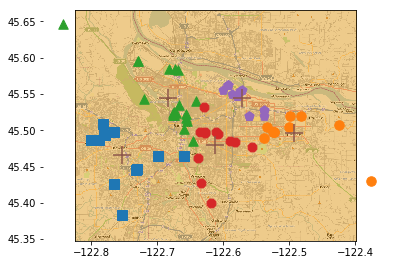

In [31]:
clusterClubs(5)

[[1 2 3]
 [4 5 6]]
[[1 2 3]
 [4 5 6]]
